In [6]:
#import os
import sys
sys.path.append("../python/")
from helpers import *

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tkr

from scipy.stats import ttest_ind # for independent t-test

In [7]:
SENSITIVITY_RESULTS_DIR = '../../results/sensitivity-tests'
SCENARIO_LIST = ["Pr_Im", "PrPo_Im", "Pr_PoIm", "Pr_Po_Im"]

In [3]:
def getPerformanceDataFrame():
    result_file_list = getListOfFiles(SENSITIVITY_RESULTS_DIR)
    df = pd.DataFrame()
    for filename in result_file_list:
        if "scenario_resolution_" in filename:
            performance_dict = json.load(open(filename))
            performance_df = pd.DataFrame(performance_dict["metrics"])
            performance_df['epoch'] = performance_df.index + 1
            performance_df["resolution"] = performance_dict["image_size"]
            performance_df["scenario"] = performance_dict["scenario"]
            performance_df["best_val_accuracy"] = performance_dict["best_val_accuracy"]
            performance_df["trial"] = int(filename.split("_")[-1].split(".")[0])
            df = df.append(performance_df, ignore_index=True)
    return(df)

In [15]:
dp = getPerformanceDataFrame()

In [50]:
dpagg = dp.groupby(['resolution','scenario','trial']).agg('max')
dpagg.iloc[:10,:]

loss  accuracy  val_loss  val_accuracy  epoch  \
resolution scenario trial                                                      
64         PrPo_Im  1      0.602230  0.991584  0.788555      0.855446     10   
                    2      0.493883  1.000000  0.664119      0.926733     10   
                    3      0.359673  0.999505  0.637803      0.940594     10   
                    4      0.272108  1.000000  0.636160      0.962376     10   
                    5      0.181736  0.999010  0.609957      0.978218     10   
                    6      0.131402  1.000000  0.603598      0.978218     10   
                    7      0.080410  1.000000  0.491083      0.982178     10   
                    8      0.048321  1.000000  0.446281      0.982178     10   
                    9      0.046163  1.000000  0.260742      0.998020     10   
                    10     0.067570  1.000000  0.172581      1.000000     10   

                           best_val_accuracy  
resolution scenario trial                     
64         PrPo_Im  1               0.855446  
                    2               0.926733  
                    3               0.940594  
                    4               0.962376  
                    5               0.978218  
                    6               0.978218  
                    7               0.982178  
                    8               0.982178  
                    9               0.998020  
                    10              1.000000

In [30]:
dp[dp.trial==10]

,loss,accuracy,val_loss,val_accuracy,epoch,resolution,scenario,best_val_accuracy,trial
170,0.324196,0.914851,0.283845,0.772277,1,224,Pr_PoIm,0.99802,10
171,0.096184,0.989604,0.368268,0.728713,2,224,Pr_PoIm,0.99802,10
172,0.040297,0.997525,0.175393,0.996040,3,224,Pr_PoIm,0.99802,10
173,0.019298,0.999010,0.089824,0.996040,4,224,Pr_PoIm,0.99802,10
174,0.013178,0.999505,0.020852,0.996040,5,224,Pr_PoIm,0.99802,10
...,...,...,...,...,...,...,...,...,...
1145,0.000743,1.000000,0.013002,0.996040,6,128,Pr_Po_Im,1.00000,10
1146,0.000239,1.000000,0.005298,0.996040,7,128,Pr_Po_Im,1.00000,10
1147,0.000205,1.000000,0.001823,1.000000,8,128,Pr_Po_Im,1.00000,10
1148,0.002293,1.000000,0.001637,1.000000,9,128,Pr_Po_Im,1.00000,10


<AxesSubplot:xlabel='epoch', ylabel='val_accuracy'>

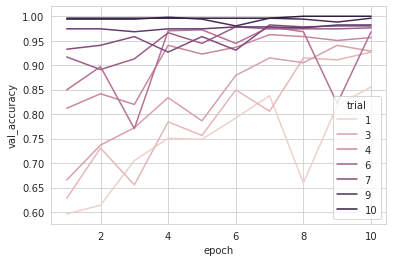

In [42]:
dd = dp[(dp.resolution == 64) &(dp.scenario == "PrPo_Im")]
sns.lineplot(x= 'epoch', y = 'val_accuracy', data = dd, hue = 'trial')

In [13]:
def plotMeanAccuracyLoss():
    df = getPerformanceDataFrame()
    melted_df = df.melt(id_vars = ["epoch", "resolution", "scenario"], value_vars = ["loss", "accuracy", "val_loss", "val_accuracy"], var_name = "metric", value_name = "value")
    melted_df["type"] = None
    melted_df.loc[melted_df.metric.isin(["loss", "val_loss"]), "type"] = "Loss"
    melted_df.loc[melted_df.metric.isin(["accuracy", "val_accuracy"]), "type"] = "Accuracy"
    
    num_scenarios = len(df.scenario.unique())
    num_resolutions = len(df.resolution.unique())
    num_epochs = df.epoch.max()
    sns.set_style("whitegrid")
    g = sns.FacetGrid(melted_df, col="scenario", row="type", sharey = False)
    g.map_dataframe(sns.lineplot, x = "epoch", y = "value", style = "metric", hue = "resolution", palette= sns.color_palette("Set1", n_colors=num_resolutions) )
    g.set_axis_labels("Epoch", "",  fontsize=14)
    g.add_legend( fontsize=16) 
    ## Customize legend
    g._legend.texts[0].set_text("Resolution")
    g._legend.texts[num_resolutions + 1].set_text("") #Data
    g._legend.texts[num_resolutions + 2].set_text("Training")
    g._legend.texts[num_resolutions + 3].set_text("Validation")    
    g._legend.texts[num_resolutions + 4].set_text("")    
    g._legend.texts[num_resolutions + 5].set_text("")    
    g._legend.legendHandles[num_resolutions + 4].set_linewidth(0)
    g._legend.legendHandles[num_resolutions + 5].set_linewidth(0)    
    g._legend._legend_box.sep = 5
    axes = g.axes
    for row, axlist in enumerate(axes):
        if row==0:
            for col, axis in enumerate(axes[row]):
                axes[row, col].set_ylim(0, 1)#.75 
                axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].xaxis.set_major_locator(tkr.AutoLocator())
                axes[row, col].set_title("Scenario: " + 
                                         str(axes[row, col].title).split("scenario = ")[1].split(")")[0].split("\'")[0], fontsize=16)
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Loss", fontsize=14)
        elif row==1:
            for col, axis in enumerate(axes[row]):
                axes[row, col].set_ylim(0.5, 1)
                axes[row, col].set_xlim(1, num_epochs)
                axes[row, col].set_title("")
                if col != 0:
                    axes[row, col].get_yaxis().set_ticklabels([])
                else:
                    axes[row, col].set_ylabel("Accuracy", fontsize=14)
    g.savefig("../../figures/scenario_resolution_performance.png", dpi=180)
    return(g)

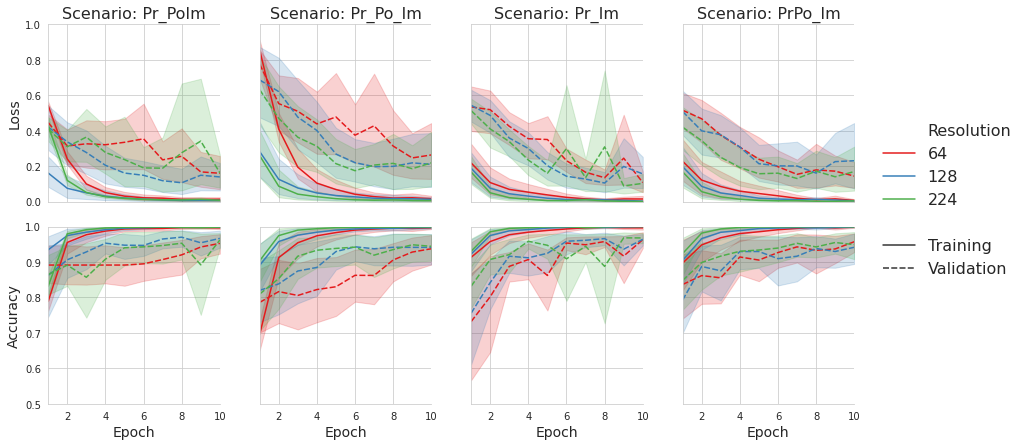

In [14]:
gg = plotMeanAccuracyLoss()

In [226]:
def testMeanValidationAccuracy():
    df = getPerformanceDataFrame()
    
    df = df[['scenario', "resolution", "trial", 'best_val_accuracy']].drop_duplicates()
    #df1['resolution'] = df1['resolution'].map(str)
    df = df.melt(id_vars = ['scenario', "resolution", "trial"], value_vars = ["best_val_accuracy"], var_name = "metric", value_name = "value")
    
    dfacc = df.groupby(["scenario", "resolution"]).mean()
    dfacc = dfacc.drop(["trial"], axis = 1)
    dfacc.columns = ['mean']
    dfacc['stdev'] = df.groupby(["scenario", "resolution"]).std()['value']
    print(np.round(dfacc,2))
    for s in SCENARIO_LIST:
        print(s)
        dfs = df[df.scenario==s]
        print("Test difference between resolutions 64 and 128")
        print(ttest_ind(dfs.loc[dfs.resolution==64,'value'], dfs.loc[dfs.resolution==128,'value'], equal_var=False))
        print("Test difference between resolutions 64 and 224")
        print(ttest_ind(dfs.loc[dfs.resolution==64,'value'], dfs.loc[dfs.resolution==224,'value'], equal_var=False))    
    return
testMeanValidationAccuracy()

                     mean  stdev
scenario resolution             
PrPo_Im  64          0.96   0.04
         128         0.96   0.05
         224         0.96   0.05
Pr_Im    64          0.98   0.03
         128         0.97   0.03
         224         0.97   0.03
Pr_PoIm  64          0.96   0.04
         128         0.97   0.04
         224         0.97   0.04
Pr_Po_Im 64          0.94   0.07
         128         0.95   0.07
         224         0.95   0.06
Pr_Im
Test difference between resolutions 64 and 128
Ttest_indResult(statistic=0.01976319227745044, pvalue=0.9844497250404811)
Test difference between resolutions 64 and 224
Ttest_indResult(statistic=0.24360063513619826, pvalue=0.8103062006606452)
PrPo_Im
Test difference between resolutions 64 and 128
Ttest_indResult(statistic=0.12736637270221182, pvalue=0.9000692161378825)
Test difference between resolutions 64 and 224
Ttest_indResult(statistic=0.06680323542374512, pvalue=0.9474847347557567)
Pr_PoIm
Test difference between resoluti

In [17]:
def plotSummaryValidationAccuracy(type="box", facet=True):
    df = getPerformanceDataFrame()    
    df = df[['scenario', "resolution", "trial", 'best_val_accuracy']].drop_duplicates()
    num_resolutions = len(df.resolution.unique())
    df.resolution = df.resolution.astype(object)
    df = df.melt(id_vars = ['scenario', "resolution", "trial"], value_vars = ["best_val_accuracy"], var_name = "metric", value_name = "value")    
    if facet==True:
        g = sns.FacetGrid(df, col="scenario", sharey = True)
        if type=="box":
            g.map_dataframe(sns.boxplot, x = "resolution", y = "value", hue = "resolution", 
                        palette= sns.color_palette("Set1", n_colors=num_resolutions), dodge =False,
                        showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"})#, capsize = .2, errwidth=1.2)
            g.set(ylim =(.85,1.01))
        elif type=="point":
            g.map_dataframe(sns.pointplot, x = "resolution", y = "value",  capsize = .2, errwidth=1.2)
            g.set(ylim =(.89,1.0))        
        g.set_axis_labels("Resolution", "Validation Accuracy")
        axes = g.axes
        for row, axlist in enumerate(axes):
            for col, axis in enumerate(axes[row]):
                axes[row,col].set_title("Scenario: " + 
                                     str(axes[row,col].title).split("scenario = ")[1].split(")")[0].split("\'")[0])
        g.savefig("../../figures/scenario_resolution_validation_accuracy_" + type + "plot.png", dpi=180)
    elif facet==False:
        #plt.figure(figsize=(14,4))
        #ax = plt.subplot(121)
        if type=="box":
            g = sns.boxplot( x = "scenario", y = "value", hue = "resolution", data = df, 
                            showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"},
                            palette= sns.color_palette("Set1", n_colors=num_resolutions))#, ax=ax)
        elif type=="bar":
            g = sns.barplot( x = "scenario", y = "value", hue = "resolution", data = df,  ci=None,
                            #showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"gray"},
                            palette= sns.color_palette("Set1", n_colors=num_resolutions))#, ax=ax)
        elif type=="point":
            g = sns.pointplot(x = "scenario", y = "value", hue = "resolution", data = df, palette= sns.color_palette("Set1", n_colors=num_resolutions), dodge=True,capsize = .2, errwidth=1.2, boxprops=dict(alpha=.3))#, ax=ax)            
        g.legend(bbox_to_anchor=(1.05, 1), loc=2, title= "Resolution",borderaxespad=0.)
        g.set(xlabel="Scenario", ylabel="Validation Accuracy")
        g.get_figure().tight_layout()
        g.get_figure().savefig("../../figures/scenario_resolution_validation_accuracy_facet_" + type + "plot.png", dpi=180)
    return

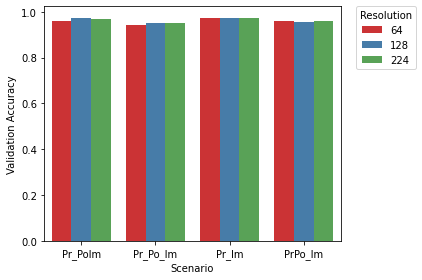

In [18]:
plotSummaryValidationAccuracy("bar", facet=False)

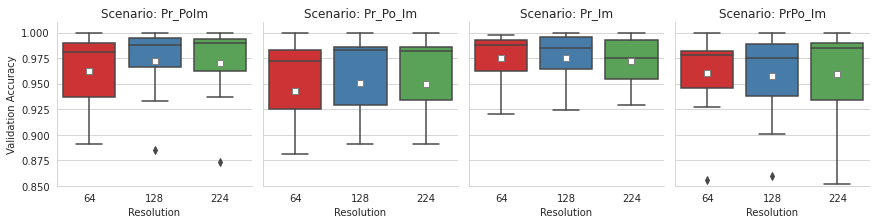

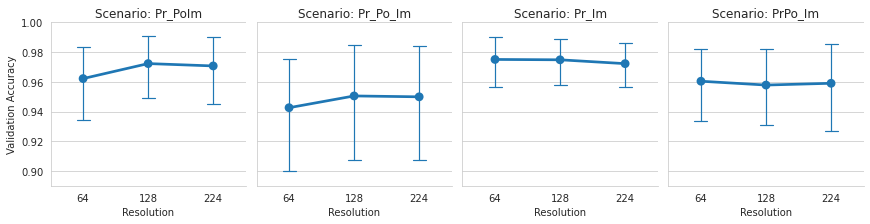

In [202]:
plotSummaryValidationAccuracy("box", facet=True)
plotSummaryValidationAccuracy("point", facet=True)

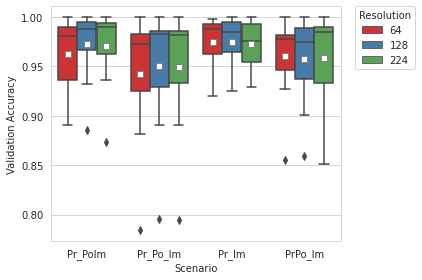

In [223]:
plotSummaryValidationAccuracy("box", facet=False)

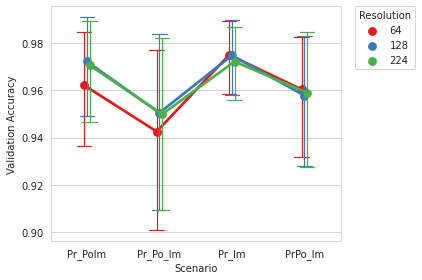

In [224]:
plotSummaryValidationAccuracy("point", facet=False)